# Kickstarting Kickstarter

# Project Introduction

The goal of the project is to investigate Kickstarter dataset to discover what makes a project successful. We will be exploring machine learning model for predicting the success or failure of any given Kickstarter. Kickstarter Success is defined by "Funding Goal has been Reached within Time Limit"

Success is related to paramaters such as backers, pledged, and state

Data Set -- https://www.kaggle.com/kemical/kickstarter-projects

Data File -- ks-projects201801.csv or https://webrobots.io/kickstarter-datasets/

# 1 -- Data Analysis & Cleaning

Through Exploratory Data Analysis (EDA), we analyse and clean the data to observe if there are any interesting findings and correlations

### Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud

### Data Observation

In [2]:
## Read File and Observe Content of File
kick = pd.read_csv("/Users/wonghuiee/Google Drive/Xccelerate - Data Science/02MachineLearning/Group Project - Kickstarter/Xccelerate Kickstarter -- ks-projects201801.csv")
kick.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
## How many rows and columns? 
## There are 378661 Rows and 15 Columns
kick.shape

(378661, 15)

In [4]:
## Any missing value?
## Quite a clean dataset, few missing values under category name and usd pledged
kick.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [5]:
## Main Category will help keep dimensionality low after one hot encoding
kick.main_category.value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

In [6]:
## Sub Category
kick.category.value_counts()

Product Design     22314
Documentary        16139
Music              15727
Tabletop Games     14180
Shorts             12357
                   ...  
Residencies           69
Letterpress           49
Chiptune              35
Literary Spaces       27
Taxidermy             13
Name: category, Length: 159, dtype: int64

In [7]:
## convert to datetime format
kick["deadline"] = pd.to_datetime(kick["deadline"])
kick["launched"] = pd.to_datetime(pd.to_datetime(kick["launched"]).dt.date)

In [8]:
kick.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

In [9]:
## engineer duration variable
kick["duration"] = (kick.deadline - kick.launched).astype("timedelta64[h]")

In [10]:
def categorical_with_per_count(kick, feature):
    ## calculate frequency of the categorical feature with %
    ## sorted in descending order
    freq_merged = pd.concat([kick[feature].value_counts(normalize=True) * 100,
    kick[feature].value_counts(normalize=False)], axis=1)
    ## rename columns
    freq_merged.columns = [feature + '_%', feature + '_count']
    return freq_merged

categorical_with_per_count(kick, "state")

,state_%,state_count
failed,52.215306,197719
successful,35.376234,133956
canceled,10.241086,38779
undefined,0.940683,3562
live,0.739184,2799
suspended,0.487507,1846


### Data Cleaning -- Finding Anomalies in the Data

A for loop to run through each column to help identify any types of values in the data that are warped or in a different format than other values in same column

In [11]:
kick.drop(columns=["ID"],inplace=True)

In [12]:
for column in list(kick.columns):
    print(kick[column].value_counts())

New EP/Music Development                           41
Canceled (Canceled)                                13
N/A (Canceled)                                     11
Music Video                                        11
Debut Album                                        10
                                                   ..
LESLIE PERRY : The Story Man                        1
Launch a Traveling Exhibit, Share the Jini Love     1
Help us start up Sauces 'n' Sweets!                 1
Phochron XA Film Camera Shutter Speed Tester        1
Tears of a Clown                                    1
Name: name, Length: 375764, dtype: int64
Product Design     22314
Documentary        16139
Music              15727
Tabletop Games     14180
Shorts             12357
                   ...  
Residencies           69
Letterpress           49
Chiptune              35
Literary Spaces       27
Taxidermy             13
Name: category, Length: 159, dtype: int64
Film & Video    63585
Music           51918
Publ

**Missing Values -- Where countries are N,0"**

After looking through the value counts above, 'N,0"' is found in the country column. As there is no clear way of identifying which country it means (and it would be a leap of logic to assume it is the same as 'NO'), we will reclassify it as 'Unknown'.

In [13]:
kick[kick["country"] == 'N,0"'][:5]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
169,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06,555.00,undefined,0,"N,0""",NaN,555.00,6500.00,1080.0
328,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53,504.0
632,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00,720.0
647,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00,576.0
749,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00,648.0


### Success is related to paramaters such as [state]  [backers]   [pledged]. We focus on converting these parameters for machine learning classifiers stage.

### STATE -- Consolidate "State" to "Successful" and "Failed"

"State" is the identified target variable. 

From a basic value counts of the column, we can see that it is currently not a binary column (success/failure).

Values that fall under "undefined" and "live" will be removed. "undefined" is difficult to determine whether they are success or failure. "live" indicates ongoing projects which we cannot evaluate success yet.

Values that fall under "cancelled" or "suspended" will be considered as "failed"

In [14]:
kick.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [15]:
## condensed "state" to only "successful" and "failed"
kick = kick[(kick["state"] != "undefined") & (kick["state"] != "live")]
kick["state"] = kick["state"].replace({"canceled":"failed", "suspended":"failed"})
kick.state.value_counts()

failed        238344
successful    133956
Name: state, dtype: int64

In [16]:
## ~98% of data retained
kick.shape

(372300, 15)

### STATE -- Convert "State" to Binary Format

For the modelling section later on, it could be useful to have success / failure as a binary number rather than as a string. We will create a new column for "State" binary format

However for the EDA, it will be easier to visualise "Successful" and "Failure", so we will drop the "state" column later on

In [17]:
kick["target"] = [1 if i == "successful" else 0 for i in kick.state]
kick["target"].value_counts()

0    238344
1    133956
Name: target, dtype: int64

In [18]:
kick.isnull().sum()

name                  4
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         234
usd_pledged_real      0
usd_goal_real         0
duration              0
target                0
dtype: int64

### BACKERS -- Overview

It could be interesting to look at the relationship between the number of backers and the success of a project. However it is important to note that the backers are part of the result and will skew any prediction model later on. We will be looking at the backers to confirm our intuition that higher number of backers will lead to a greater chance of Kickstarter success, but we will not be using it as part of our model

**Most projects are under 50,000 backers**

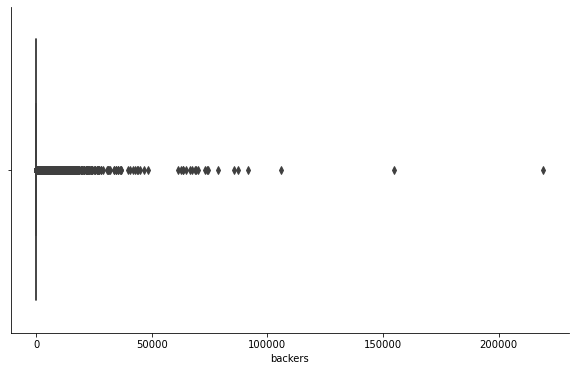

In [19]:
plt.subplots(figsize=(10,6))
sns.boxplot(data=kick, x="backers")
sns.despine(left=False, bottom=False, right=True)

### BACKERS -- Overview in Backers_log

The distribution of backers is heavily influenced by outliers and it will be difficult to perfrom EDA in any meaningful way if the graphs are as above. Therefore, we perform a log calculation to the column to allow for better visualisation on a logarithmic scale

In [20]:
## Backers_log column created
kick["backers_log"] = [0 if i==0 else np.log10(i) for i in kick.backers]
kick.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,0.0,1533.95,1416.0,0,0.000000
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,100.0,2421.0,30000.00,1440.0,0,1.176091
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,220.0,45000.00,1080.0,0,0.477121
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,1.0,5000.00,720.0,0,0.000000
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,1283.0,1283.0,19500.00,1344.0,0,1.146128


We can see a much cleare distribution after creating the log scale. Most values are observed to be between 0 (10^0) to 100 (10^2). Median is 12

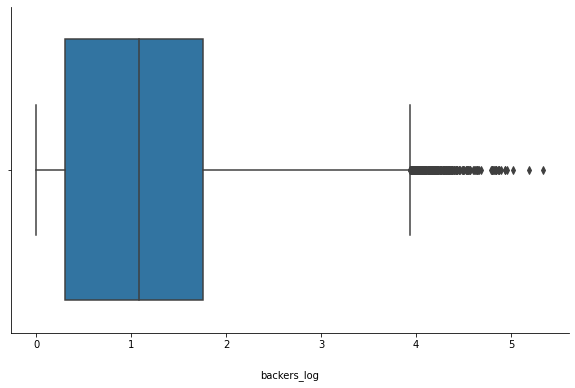

In [21]:
## Backers_log plotting
plt.subplots(figsize = (10,6))
plt.xlabel("Number of Backers (Log Scaled)", labelpad=20)
plt.xticks(range(6))
plt.xlabel(["1", "10", "100", "1000", "10000", "100000"])

colors = ["#97AABD","#C96567"]
sns.boxplot(data=kick, x = "backers_log")
sns.despine(left=False, bottom=False, right=True)

In [22]:
kick.backers.median()

12.0

### BACKERS -- Backers vs Success

**75-80% of the data faills within 100 backers**. This is indicated by the boxplot and confirmed by the value counts

In [23]:
back_top100 = kick.backers.value_counts()[:100].sum()
back_top100_per =(kick.backers.value_counts()[:100].sum())/(kick.backers.value_counts().sum())*100
print("Top 100 Backers in Total: ", back_top100)
print("Top 100 Backers are ", back_top100_per, "% of Total Backers")

Top 100 Backers in Total:  312180
Top 100 Backers are  83.85173247381145 % of Total Backers


From the graph below, we can see that haveing 20-30 backers is roughly the target threshold Kickstarters will want to start having around a 50% chance of being successful in meeting their goals

failed        230507
successful     82101
Name: state, dtype: int64


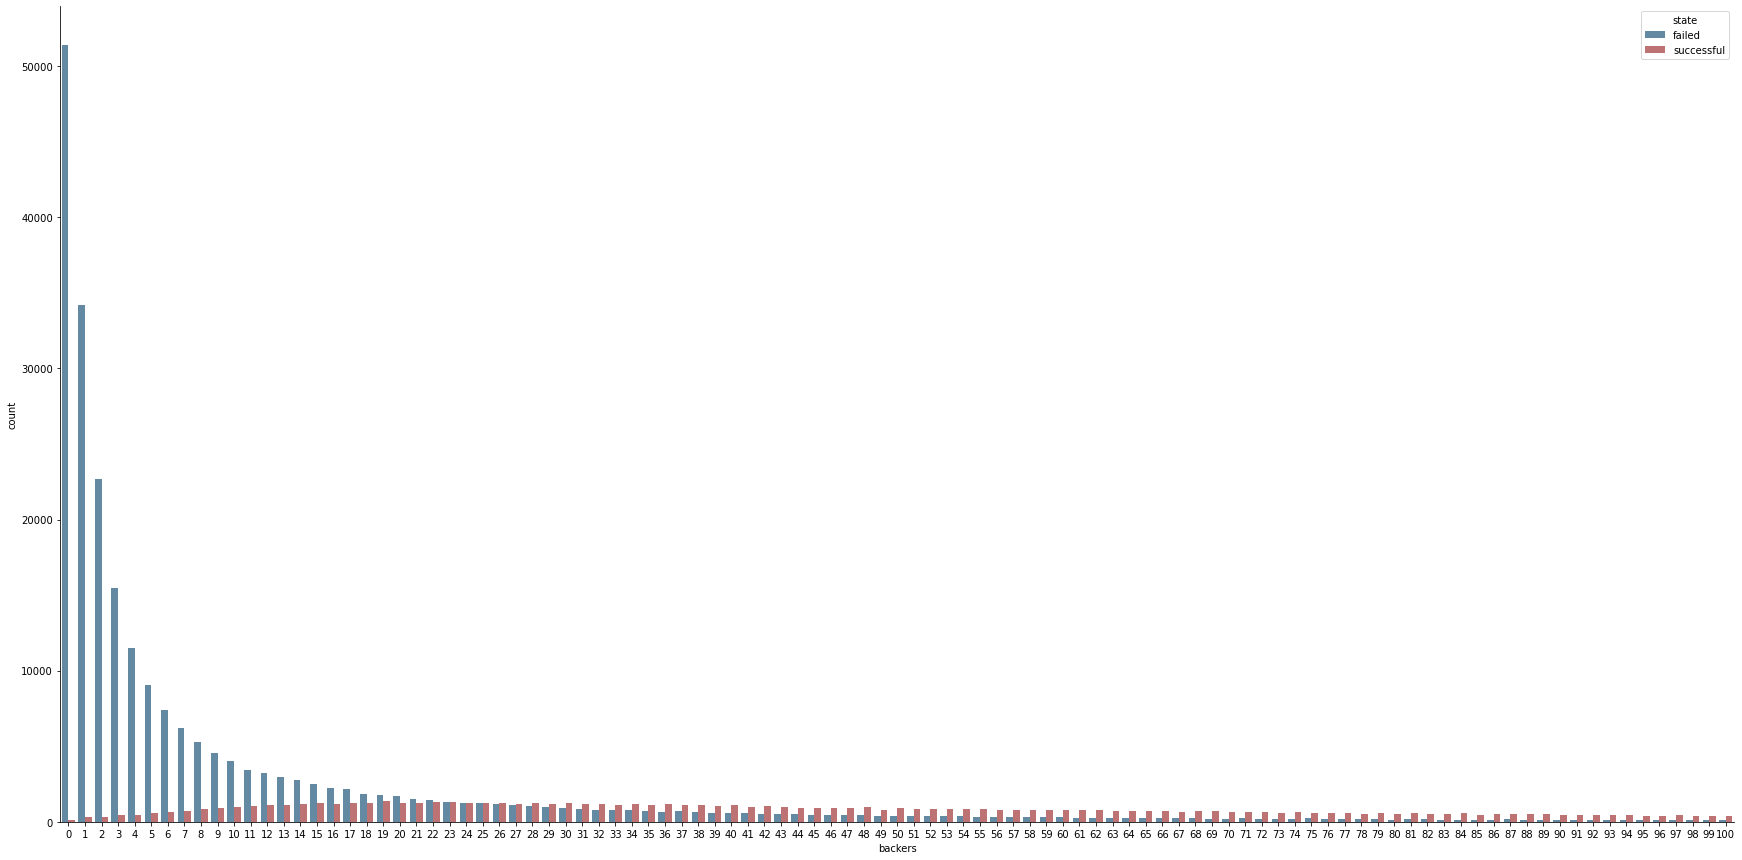

In [24]:
kick_back_small = kick[kick["backers"]<=100]
print(kick_back_small.state.value_counts())

plt.subplots(figsize=(30,15))
colors = ["#588BAE","#C96567"]
sns.set_palette(sns.color_palette(colors))
sns.countplot(data=kick_back_small, x="backers", hue="state")
sns.despine(left=False, bottom=False, right=True)

Taking a selection of large numbers of backers, we can see a similar trend. As the number of backers increases, the relative success rate nominally increase as well

In [25]:
kick_back_mid = kick[(kick["backers"]>=500) & (kick["backers"]<=1000)]
kick_back_mid.state.value_counts()

successful    6058
failed         477
Name: state, dtype: int64

This is further confirmed when looking at the log backers column. The successful Kickstarters seem normally distributed when logged, but it is still clear that projects with few backers are much more likely to fail

Text(0.5, 0, 'Number of Backers (Log Scaled)')

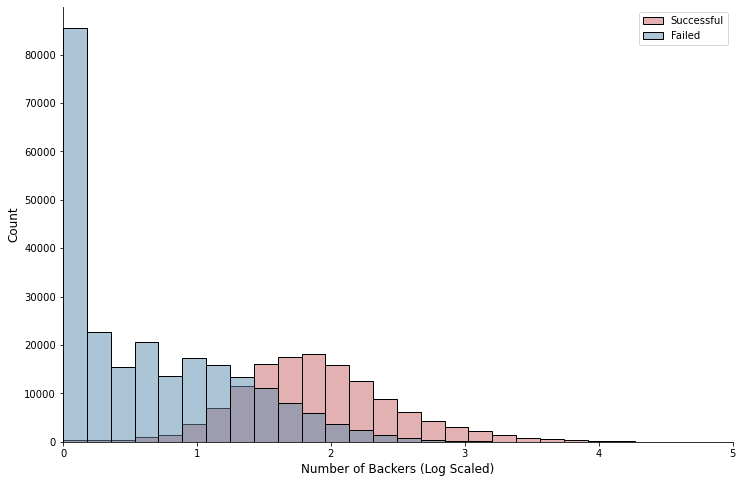

In [26]:
plt.subplots(figsize=(12,8))

colors = ["#588BAE","#C96567"]
sns.set_palette(sns.color_palette(colors))
sns.histplot(data=kick, x="backers_log", bins=30, hue="state")
sns.despine(left=False, bottom=False, right=True)

plt.legend(labels=["Successful", "Failed"], loc="upper right", prop={"size":10})
plt.xlim(0,5)
plt.xticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Number of Backers (Log Scaled)", fontsize=12)

The KDE plot shows the same conclusion in a similar way, although not very clearly. If you have few backers, you are highly likely to fail. There are much fewer cases of having a high number of backers, but the chance of success is higher which is why it is easier to see a more solid orange line further to the right

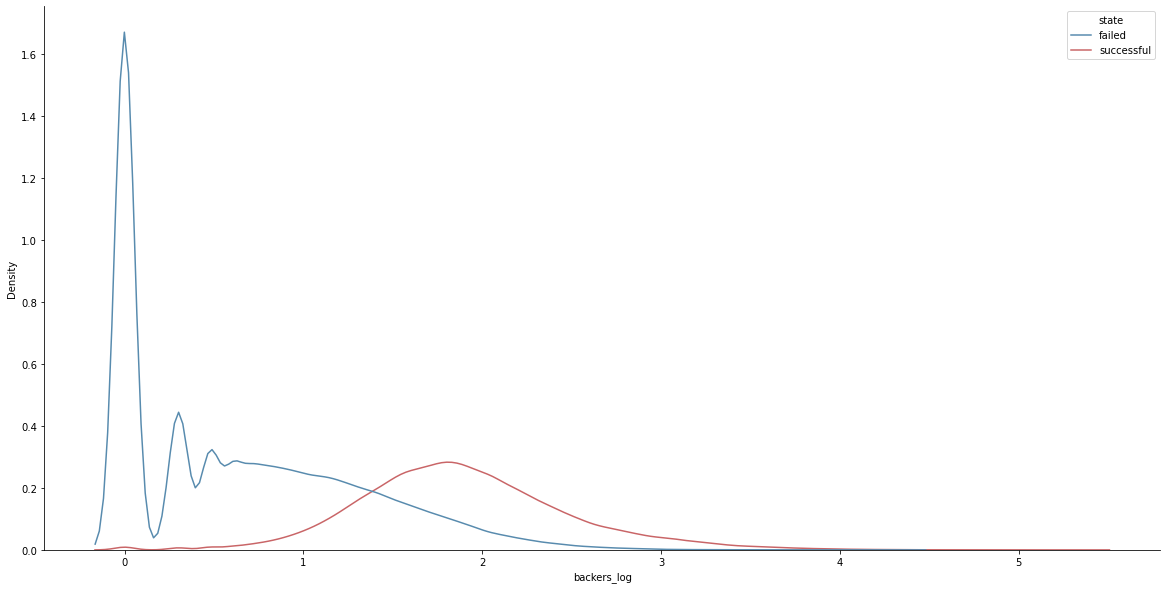

In [27]:
plt.subplots(figsize=(20,10))
plt.legend(labels=["Successful", "Failed"], loc="upper right", prop={"size":10})

colors = ["#588BAE","#C96567"]
sns.set_palette(sns.color_palette(colors))
sns.kdeplot(data=kick, x="backers_log", hue="state")
sns.despine(left=False, bottom=False, right=True)

### BACKERS -- Outliers
Interesting finding just to see what the crazy outliers in terms of backing

In [28]:
kick[kick.backers>=100000]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log
75900,Fidget Cube: A Vinyl Desk Toy,Product Design,Design,USD,2016-10-20,15000.0,2016-08-30,6465690.30,successful,154926,US,13770.00,6465690.30,15000.0,1224.0,1,5.190124
187652,Exploding Kittens,Tabletop Games,Games,USD,2015-02-20,10000.0,2015-01-20,8782571.99,successful,219382,US,8782571.99,8782571.99,10000.0,744.0,1,5.341201
292244,"Bring Reading Rainbow Back for Every Child, Ev...",Web,Technology,USD,2014-07-02,1000000.0,2014-05-28,5408916.95,successful,105857,US,5408916.95,5408916.95,1000000.0,840.0,1,5.024720


### PLEDGED -- Pledged vs Success

Total Pledged Amount. We cannot used most pledged because the numbers are in different currencies

In [29]:
## Total Pldeged Amount
## We cannot used most pledged because the numbers are in different currencies
kick.pledged.sum()

3633016851.24

In [30]:
## Pledged vs Success
kick.sort_values(by="pledged", ascending=False)[:5]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log
157270,"Pebble Time - Awesome Smartwatch, No Compromises",Product Design,Design,USD,2015-03-28,500000.0,2015-02-24,20338986.27,successful,78471,US,20338986.27,20338986.27,500000.0,768.0,1,4.894709
250254,COOLEST COOLER: 21st Century Cooler that's Act...,Product Design,Design,USD,2014-08-30,50000.0,2014-07-08,13285226.36,successful,62642,US,13285226.36,13285226.36,50000.0,1272.0,1,4.796866
216629,"Pebble 2, Time 2 + All-New Pebble Core",Product Design,Design,USD,2016-06-30,1000000.0,2016-05-24,12779843.49,successful,66673,US,12779843.49,12779843.49,1000000.0,888.0,1,4.823950
289915,Kingdom Death: Monster 1.5,Tabletop Games,Games,USD,2017-01-08,100000.0,2016-11-25,12393139.69,successful,19264,US,5228482.00,12393139.69,100000.0,1056.0,1,4.284746
282416,Pebble: E-Paper Watch for iPhone and Android,Product Design,Design,USD,2012-05-19,100000.0,2012-04-11,10266845.74,successful,68929,US,10266845.74,10266845.74,100000.0,912.0,1,4.838402


USD Pledged vs Success. We used the converted USD_Pledged. There are some currencies which are also not converted, at least its 95% accuracy. Both Pledged and USD_Pledged have similar ranking since most projects are in the US / USD

In [31]:
## Total USD_Pldeged Amount
kick.usd_pledged_real.sum()

3405951260.4600005

In [32]:
## USD Pledged vs Success
kick.sort_values(by="usd_pledged_real", ascending=False)[:5]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log
157270,"Pebble Time - Awesome Smartwatch, No Compromises",Product Design,Design,USD,2015-03-28,500000.0,2015-02-24,20338986.27,successful,78471,US,20338986.27,20338986.27,500000.0,768.0,1,4.894709
250254,COOLEST COOLER: 21st Century Cooler that's Act...,Product Design,Design,USD,2014-08-30,50000.0,2014-07-08,13285226.36,successful,62642,US,13285226.36,13285226.36,50000.0,1272.0,1,4.796866
216629,"Pebble 2, Time 2 + All-New Pebble Core",Product Design,Design,USD,2016-06-30,1000000.0,2016-05-24,12779843.49,successful,66673,US,12779843.49,12779843.49,1000000.0,888.0,1,4.823950
289915,Kingdom Death: Monster 1.5,Tabletop Games,Games,USD,2017-01-08,100000.0,2016-11-25,12393139.69,successful,19264,US,5228482.00,12393139.69,100000.0,1056.0,1,4.284746
282416,Pebble: E-Paper Watch for iPhone and Android,Product Design,Design,USD,2012-05-19,100000.0,2012-04-11,10266845.74,successful,68929,US,10266845.74,10266845.74,100000.0,912.0,1,4.838402


# 2.1 -- Data Visualisation -- General Statistics
We want to explore which categories of Kickstarters are more likely to success. The following graphs attempt to visualise this.

### Kickstarter projects are approximately 1/3 success and 2/3 failed. 
**Observation** Film stands out as a big category that is likely to fail.

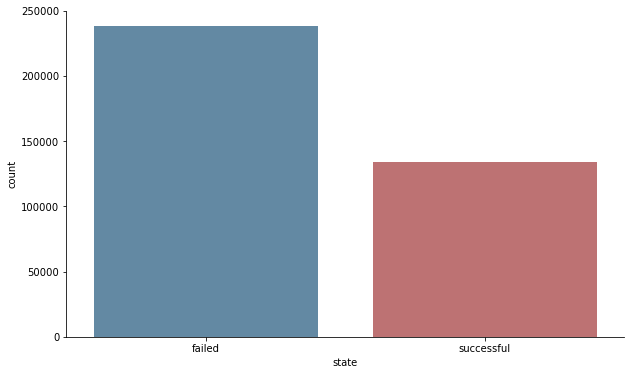

In [33]:
plt.subplots(figsize=(10,6))

colors = ["#588BAE","#C96567"]
sns.set_palette(sns.color_palette(colors))
sns.countplot(data=kick, x="state")
sns.despine(left=False, bottom=False, right=True)


### Main Category -- Film & Video + Music together contain 30% of the total projects 

Text(0.5, 1.0, 'Main Category')

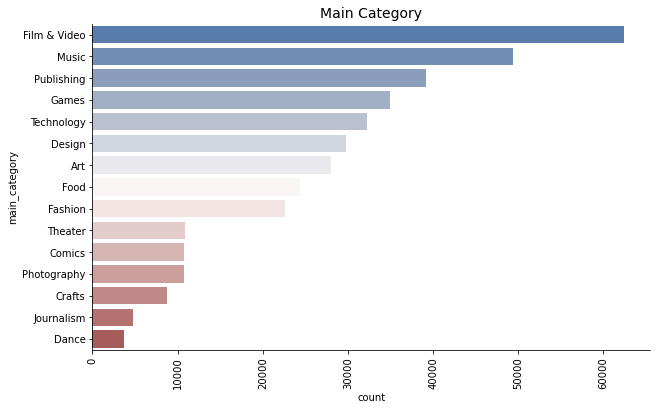

In [34]:
plt.subplots(figsize=(10,6))

sns.countplot(y=kick.main_category, order=kick["main_category"].value_counts().index, palette="vlag")
sns.despine(left=False, bottom=False, right=True)

plt.yticks(fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.title("Main Category", fontsize=14)

### Sub Categories -- Top 10 Most Successful

**Observation** Looking only at frequency may not accurately capture which categories are more likely to be successful. Having a large volume of a category does not neccessarily mean that the category is more easily funded on kickstarter

In [35]:
kick_cat=kick.groupby("category")["state"].value_counts().unstack("state")

Text(0.5, 1.0, 'Sub Categories')

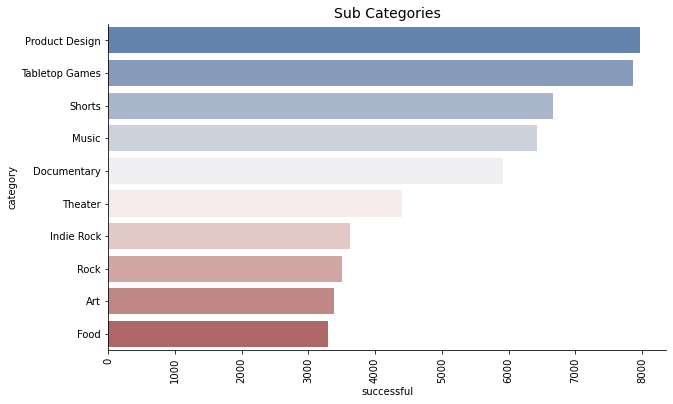

In [90]:
top_success = pd.DataFrame(kick_cat["successful"].sort_values(ascending=False)[:10])

plt.subplots(figsize=(10,6))

sns.barplot(data=top_success, y=top_success.index, x="successful",palette="vlag")
sns.despine(left=False, bottom=False, right=True)

plt.yticks(fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.title("Sub Categories", fontsize=14)


### Sub Categories -- Top 10 Most Failed

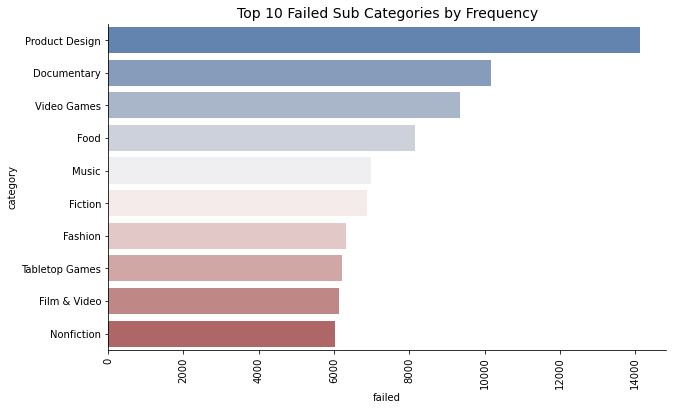

In [37]:
top_fail = pd.DataFrame(kick_cat["failed"].sort_values(ascending=False)[:10])

plt.subplots(figsize=(10,6))
plt.title("Top 10 Failed Sub Categories by Frequency", fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(rotation=90, fontsize=10)

sns.barplot(data=top_fail, y=top_fail.index, x="failed", palette="vlag")
sns.despine(left=False, bottom=False, right=True)

Residencies shows up as a relatively more "successful" category. But a closer look finds that this category to be largely random

In [38]:
kick[kick.category == "Residencies"][:5]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log
22912,"Residencia en Guanajuato para ensayo de ""La Ca...",Residencies,Dance,MXN,2017-10-12,10000.0,2017-09-12,650.00,failed,4,MX,0.00,34.29,527.51,720.0,0,0.602060
37001,Cascade Youth Dance: Commonwealth,Residencies,Dance,GBP,2014-06-30,1000.0,2014-05-26,1170.00,successful,9,GB,1969.26,2005.79,1714.35,840.0,1,0.954243
39991,Plastic Identities,Residencies,Dance,USD,2017-07-20,6500.0,2017-06-20,7106.99,successful,85,US,543.00,7106.99,6500.00,720.0,1,1.929419
49862,Peter & Co. SF Presents at The Garage,Residencies,Dance,USD,2014-08-02,4500.0,2014-07-03,805.00,failed,24,US,805.00,805.00,4500.00,720.0,0,1.380211
63571,Turn my house into a ball pit party.,Residencies,Dance,CAD,2014-11-27,1000.0,2014-10-28,1.00,failed,1,CA,0.89,0.88,877.42,720.0,0,0.000000


### Countries -- Top 10 Frequented -- 78% of the projects are from USA

To explore the effect of the country of origin, we created a separate dataframe to see the success and failure numbers by country. Since there was a hugely disproportionate number of Kickstarters originating from the US, we decided on using a percentage to better visualise the results

From the graph that no one country stands out as being exceptional at having successful Kickstarters, although some certainly perform worse than others(e.g. IT). An interesting note is that the previously unidentified "Unknown" category performs the best

In [39]:
categorical_with_per_count(kick, "country").head(n=10)

,country_%,country_count
US,78.132420,290887
GB,8.969380,33393
CA,3.928015,14624
AU,2.086758,7769
DE,1.100188,4096
FR,0.775450,2887
NL,0.760945,2833
IT,0.752619,2802
ES,0.597368,2224
SE,0.466559,1737


In [40]:
kick_country = kick.groupby("country")["state"].value_counts().unstack()

In [41]:
kick_country["s_percent"] = kick_country.successful / (kick_country.successful + kick_country.failed) *100
kick_country["f_percent"] = 100 - kick_country.s_percent
kick_country["one"] = 100

In [42]:
sum(kick_country.failed) + sum(kick_country.successful)

372300

In [43]:
kick_country

state,failed,successful,s_percent,f_percent,one
country,,,,,
AT,475,107,18.384880,81.615120,100
AU,5759,2010,25.872056,74.127944,100
BE,453,152,25.123967,74.876033,100
CA,10490,4134,28.268600,71.731400,100
CH,560,187,25.033467,74.966533,100
DE,3159,937,22.875977,77.124023,100
DK,737,360,32.816773,67.183227,100
ES,1732,492,22.122302,77.877698,100
FR,1979,908,31.451334,68.548666,100


Text(0.5, 0, '')

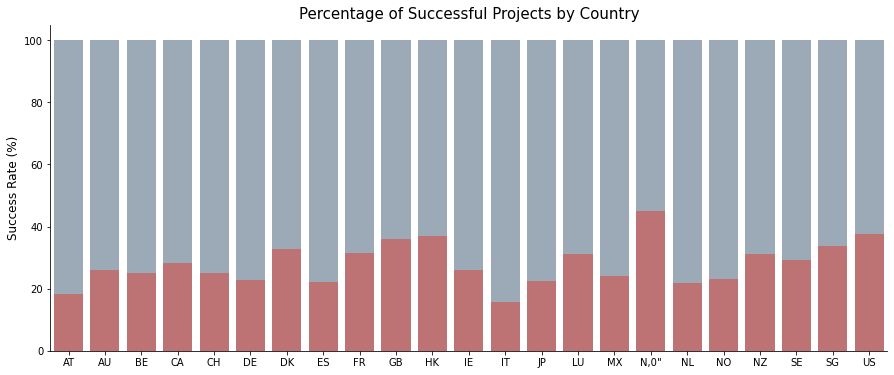

In [44]:
plt.subplots(figsize=(15,6))

sns.barplot(data=kick_country, x=kick_country.index, y="one", color="#97AABD")
sns.barplot(data=kick_country, x=kick_country.index, y="s_percent", color="#C96567")
sns.despine(left=False, bottom=False, right=True)

plt.title("Percentage of Successful Projects by Country", fontsize=15)
plt.ylabel("Success Rate (%)", fontsize=12)
plt.xlabel("", fontsize=12, labelpad=12)

# 2.2 -- Data Visualisation -- Measuring Success

### Success // Goal -- The higher the goal amount set, the less likely a project is to be successfully funded.

A brief look at the effect of how the goal amount may relate to success or failure. The higher the goal amount set, the less likely a project is to be successfully funded. This is a reasonable take as it should be harder to reach large numbers.

Below is a look with the converted USD Goal Real which provides a more accurate number since all values are converted to USD. The general shape remains the same

(0.0, 7.0)

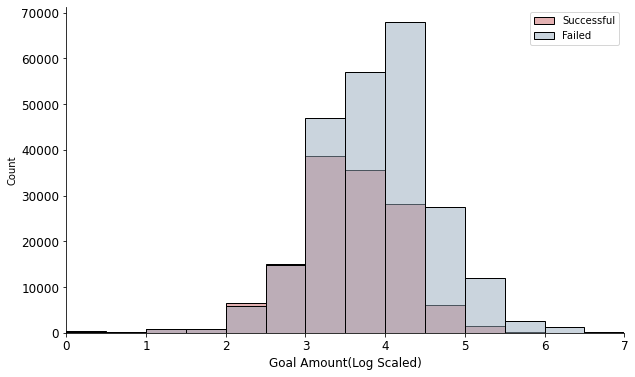

In [45]:
plt.subplots(figsize=(10,6))

colors = ["#97AABD","#C96567"]
sns.set_palette(sns.color_palette(colors))
sns.histplot(data=kick, x=np.log10(kick["goal"]), bins=20, hue="state")
sns.despine(left=False, bottom=False, right=True)

plt.legend(labels=["Successful", "Failed"], loc="upper right", prop={"size":10})
plt.xlabel("Goal Amount(Log Scaled)", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0,7)



(0.0, 7.0)

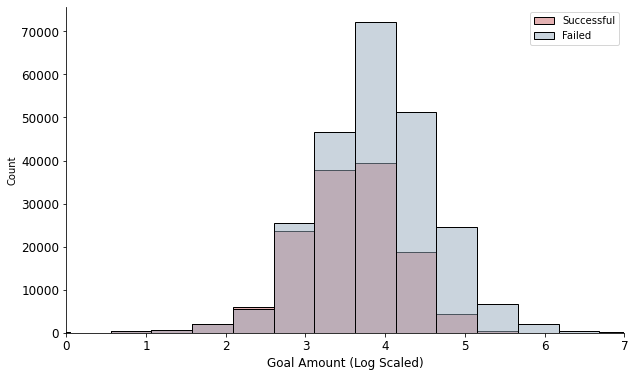

In [88]:
plt.subplots(figsize=(10,6))

colors = ["#97AABD","#C96567"]
sns.set_palette(sns.color_palette(colors))
sns.histplot(data=kick, x=np.log10(kick["usd_goal_real"]), bins=20, hue="state")
sns.despine(left=False, bottom=False, right=True)

plt.legend(labels=["Successful", "Failed"], loc="upper right", prop={"size":10})
plt.xlabel("Goal Amount (Log Scaled)", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0,7)

### Success // Goal // Pledged -- In 99% of the cases, as long as the pledged amount exceeds the goal, it is successful

**Observation** This is also how Kickstarter determines success.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


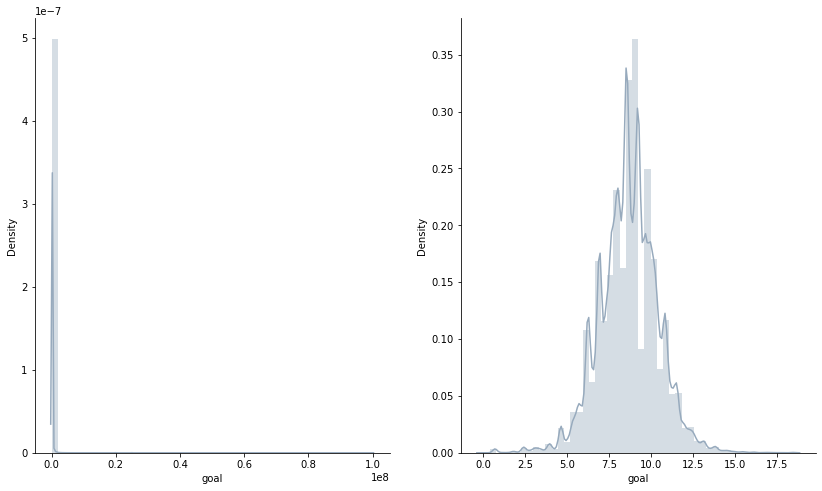

In [47]:
## Combined different plots into one: goal and log(goal)
dims = (14, 8)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=dims)
sns.distplot(kick.goal, ax=ax1)
sns.distplot(np.log1p(kick.goal), ax=ax2)
sns.despine(left=False, bottom=False, right=True)

Further look to confirm the way a "successful" state is found. In 99% of the cases, as long as the pledged amount exceeds the goal, it is successful

In [48]:
kick_pledge_goal = kick[(kick.pledged >= kick.goal)]

In [49]:
kick_pledge_goal.state.value_counts()

successful    133951
failed           996
Name: state, dtype: int64

In [50]:
kick[kick.state == "successful"]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log
5,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26,52375.00,successful,224,US,52375.00,52375.00,50000.00,840.0,1,2.350248
6,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01,1205.00,successful,16,US,1205.00,1205.00,1000.00,480.0,1,1.204120
11,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,12500.0,2013-03-09,12700.00,successful,100,US,12700.00,12700.00,12500.00,720.0,1,2.000000
14,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,5000.0,2017-04-05,94175.00,successful,761,GB,57763.78,121857.33,6469.73,672.0,1,2.881385
18,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17,250.0,2012-08-02,250.00,successful,7,US,250.00,250.00,250.00,360.0,1,0.845098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378642,ÉPOUVANTAILS : 28mm Figurines de jeux pour KIN...,Tabletop Games,Games,EUR,2017-10-31,1000.0,2017-10-04,1246.00,successful,35,FR,66.72,1452.47,1165.70,648.0,1,1.544068
378644,The Manual Bar Blade,Product Design,Design,USD,2015-12-15,3500.0,2015-11-23,6169.00,successful,120,US,6169.00,6169.00,3500.00,528.0,1,2.079181
378646,The Dog Coffee Book,Children's Books,Publishing,USD,2013-11-30,950.0,2013-10-18,1732.02,successful,31,US,1732.02,1732.02,950.00,1032.0,1,1.491362
378651,AT THE BEACH,Classical Music,Music,CAD,2014-03-22,5000.0,2014-02-20,5501.00,successful,78,CA,5019.92,4983.69,4529.81,720.0,1,1.892095


### Success // Project Length on Launched and Deadline -- Longer campaign have higher failure rates. This occurs pretty much for all categories

In [51]:
kick["proj_length"] = (kick.deadline - kick.launched).dt.days
kick["proj_length"]

0         59
1         60
2         45
3         30
4         56
          ..
378656    30
378657    27
378658    46
378659    31
378660    28
Name: proj_length, Length: 372300, dtype: int64

We are getting some outliers with project lenghts over 16000 days. These are definitely data errors and we will be converting them to the max project length of 92 days

In [52]:
kick[kick["proj_length"] >= 93]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log,proj_length
2842,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01,0.0,failed,0,US,0.0,0.0,5000.00,356808.0,0,0.0,14867
48147,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,15000.0,1970-01-01,0.0,failed,0,US,0.0,0.0,15000.00,356040.0,0,0.0,14835
75397,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01,0.0,failed,0,US,0.0,0.0,700.00,354000.0,0,0.0,14750
94579,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,4000.0,1970-01-01,0.0,failed,0,US,0.0,0.0,4000.00,354264.0,0,0.0,14761
247913,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,10000.0,1970-01-01,0.0,failed,0,US,0.0,0.0,10000.00,353592.0,0,0.0,14733
273779,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01,0.0,failed,0,US,0.0,0.0,500.00,353016.0,0,0.0,14709
319002,Student Auditions Music 2015,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01,0.0,failed,0,CH,0.0,0.0,1905.97,401736.0,0,0.0,16739


In [53]:
kick["proj_length"] = kick["proj_length"].mask(kick["proj_length"]>93, 92)

In [54]:
kick.proj_length.describe()

count    372300.000000
mean         34.175055
std          12.795045
min           1.000000
25%          30.000000
50%          30.000000
75%          37.000000
max          92.000000
Name: proj_length, dtype: float64

### Success // Currency -- No Correlation

Similar to the country, we will take a look at whether the currency has an effect on the success of failure of any given Kickstarter project

In [55]:
kick_currency = kick.groupby("currency")["state"].value_counts().unstack("state")

In [56]:
kick_currency.head()

state,failed,successful
currency,,
AUD,5766,2011
CAD,10492,4137
CHF,560,187
DKK,738,362
EUR,13032,3882


In [57]:
kick_currency["s_percent"] = kick_currency.successful / (kick_currency.successful + kick_currency.failed) *100
kick_currency["f_percent"] = 100 - kick_currency.s_percent
kick_currency["one"] = 100

In [58]:
sum(kick_currency.failed) + sum(kick_currency.successful)

372300

In [59]:
kick_currency

state,failed,successful,s_percent,f_percent,one
currency,,,,,
AUD,5766,2011,25.858300,74.141700,100
CAD,10492,4137,28.279445,71.720555,100
CHF,560,187,25.033467,74.966533,100
DKK,738,362,32.909091,67.090909,100
EUR,13032,3882,22.951401,77.048599,100
GBP,21336,12081,36.152258,63.847742,100
HKD,367,216,37.049743,62.950257,100
JPY,24,7,22.580645,77.419355,100
MXN,1249,396,24.072948,75.927052,100


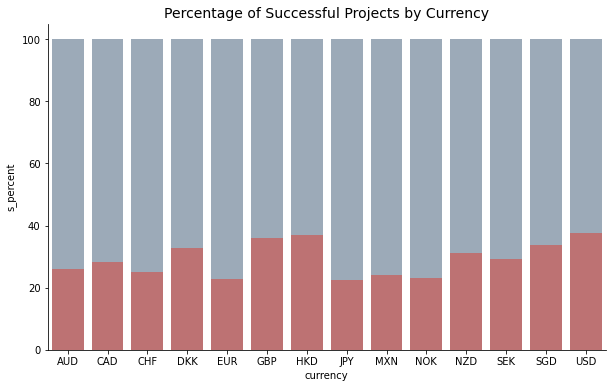

In [60]:
plt.subplots(figsize=(10,6))
plt.title("Percentage of Successful Projects by Currency", fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

sns.barplot(data=kick_currency, x=kick_currency.index, y="one", color="#97AABD")
sns.barplot(data=kick_currency, x=kick_currency.index, y="s_percent", color="#C96567")
sns.despine(left=False, bottom=False, right=True)

### Success // Characters and Words Length  -- Weak Correlation

As we are lacking information on the descriptions for the Kickstarter Projects on this dataset, we look at the next best thing - the name. We believe there could be a relationship (even if not a strong correlation) between the length of the name (both in characters or words) and the success of a Kickstarter. 

4 rows have missing names. To avoid erros will fill with "None"

In [61]:
kick[kick.name.isna()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log,proj_length
166851,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01,100.0,failed,1,US,100.00,100.00,200000.00,1416.0,0,0.000000,59
307234,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19,196.0,failed,12,GB,317.73,316.05,3224.97,432.0,0,1.079181,18
309991,NaN,Product Design,Design,USD,2016-07-18,2500.0,2016-06-18,0.0,failed,0,US,0.00,0.00,2500.00,720.0,0,0.000000,30
338931,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06,220.0,failed,5,US,220.00,220.00,35000.00,696.0,0,0.698970,29


In [62]:
kick.name = kick.name.fillna("None")

Create column for lenght of title in characters / words

In [63]:
kick["name_words"] = [len(i.split()) for i in kick.name]
kick["name_chars"] = [len(i) for i in kick.name]

In [64]:
kick.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log,proj_length,name_words,name_chars
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,0.0,1533.95,1416.0,0,0.000000,59,6,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,100.0,2421.0,30000.00,1440.0,0,1.176091,60,8,45
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,220.0,45000.00,1080.0,0,0.477121,45,3,14
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,1.0,5000.00,720.0,0,0.000000,30,7,49
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,1283.0,1283.0,19500.00,1344.0,0,1.146128,56,8,58


There is no strong indicator that the number of words will correlate to the success rate of a Kickstarter project

Text(0.5, 0, 'Number of Words')

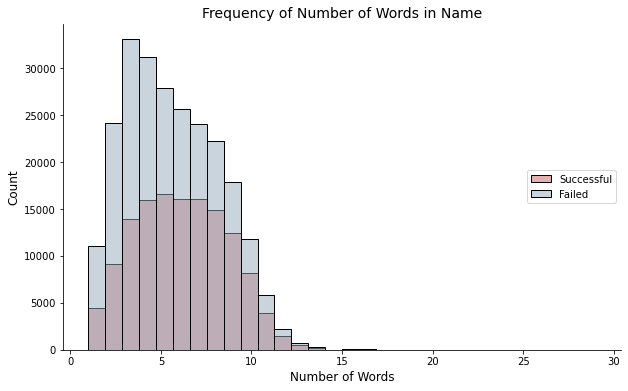

In [65]:
plt.subplots(figsize=(10,6))

sns.histplot(data=kick, x="name_words", bins=30, hue="state")
sns.despine(left=False, bottom=False, right=True)

plt.title("Frequency of Number of Words in Name", fontsize=14)
plt.legend(labels = ["Successful", "Failed"], loc="center right", prop={"size":10})
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Number of Words", fontsize=12)

These plots look slightly more interesting as there is a virtual cutoff at 60 characters. This could be because Kickstarter created a character limit. Reframing seems to show that all the longer character names are from 2010 or prior, which would confirm this.

Text(0.5, 0, 'Number of Characters')

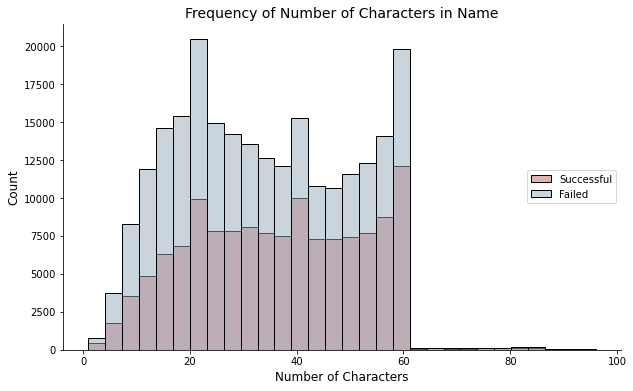

In [66]:
plt.subplots(figsize=(10,6))

sns.histplot(data=kick, x="name_chars", bins=30, hue="state")
sns.despine(left=False, bottom=False, right=True)

plt.title("Frequency of Number of Characters in Name", fontsize=14)
plt.legend(labels = ["Successful", "Failed"], loc="center right", prop={"size":10})
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Number of Characters", fontsize=12)

### Character Limit at 60, set by Kickstarter

In [67]:
kick[kick.name_chars >= 61]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,target,backers_log,proj_length,name_words,name_chars
132,"Brandi Emma promotes her new, 5-song EP becaus...",Indie Rock,Music,USD,2010-07-12,10000.0,2010-06-12,4006.0,failed,44,US,4006.0,4006.0,10000.0,720.0,0,1.643453,30,14,80
188,Raise funds for the new JonathanGluck and the ...,Rock,Music,USD,2010-09-19,4000.0,2010-07-30,30.0,failed,2,US,30.0,30.0,4000.0,1224.0,0,0.301030,51,11,65
357,Circa Vitae requests crowd fundage to record o...,Indie Rock,Music,USD,2009-11-01,2000.0,2009-08-06,80.0,failed,4,US,80.0,80.0,2000.0,2088.0,0,0.602060,87,13,81
633,Legendary Steamboat Springs Band records an al...,Country & Folk,Music,USD,2010-08-01,5500.0,2010-07-14,1310.0,failed,14,US,1310.0,1310.0,5500.0,432.0,0,1.146128,18,10,67
1048,Please Donate Money For My First Music Video S...,Country & Folk,Music,USD,2010-09-17,5000.0,2010-08-18,0.0,failed,0,US,0.0,0.0,5000.0,720.0,0,0.000000,30,11,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378478,UP COUNTRY | A film about a Maine fishing trip...,Narrative Film,Film & Video,USD,2010-07-17,4000.0,2010-06-08,4289.0,successful,109,US,4289.0,4289.0,4000.0,936.0,1,2.037426,39,13,66
378484,"Panacea's New Album ""12 Step Program"" Deserves...",Rock,Music,USD,2010-04-30,3800.0,2010-02-26,5731.0,successful,163,US,5731.0,5731.0,3800.0,1512.0,1,2.212188,63,14,83
378583,Deep Vein Thrombosis Clot Association - Suppor...,Documentary,Film & Video,USD,2010-10-06,40000.0,2010-07-08,0.0,failed,0,US,0.0,0.0,40000.0,2160.0,0,0.000000,90,9,68
378593,Uncanny Valley - a dudley ghost./miasma record...,Indie Rock,Music,USD,2010-07-05,9000.0,2010-04-07,53.0,failed,2,US,53.0,53.0,9000.0,2136.0,0,0.301030,89,9,69


The following histogram shows that there is almost certainly a character limit being enforced. The few outliers after 2011 may be due to characters being counted differently

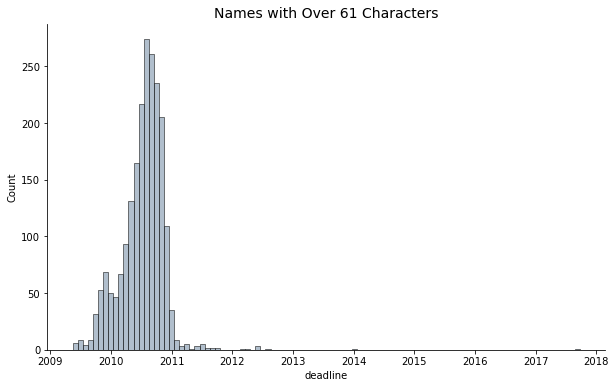

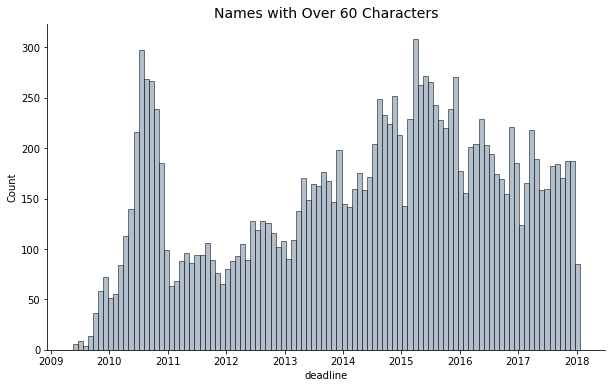

In [68]:
plt.subplots(figsize=(10,6))
sns.histplot(data=kick[kick.name_chars >= 61], x="deadline", bins=100)
sns.despine(left=False, bottom=False, right=True)
plt.title("Names with Over 61 Characters", fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()

plt.subplots(figsize=(10,6))
sns.histplot(data=kick[kick.name_chars >= 60], x="deadline", bins=100)
sns.despine(left=False, bottom=False, right=True)
plt.title("Names with Over 60 Characters", fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()

### Word Frequencies -- The most Popular Words on the Successful / Failed project name

In [69]:
## Word clouds are the simplest way of communicating word frequencies in easier mannner.
## The more a word appears in a source, the bigger and bolder it appears in the word cloud.
## It allows easy allows seeing frequent words at first glance.

def show_wordcloud(data, title = None):
    ## Split names by space and generate word counts.
    wordcloud = WordCloud(
        background_color='white',
        max_words=150,
        max_font_size=40, 
        scale=2,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

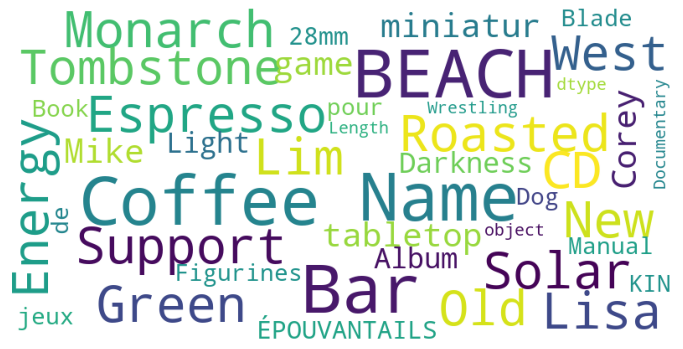

In [70]:
## Successful Project
show_wordcloud(kick[kick.state == 'successful']['name'])

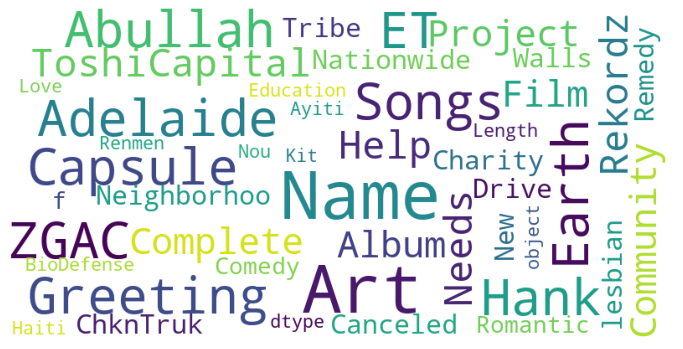

In [71]:
## Failed Project
show_wordcloud(kick[kick.state == 'failed']['name'])

# 2.3 -- Data Visualisation -- Heatmap

**Observation** Heatmap that confirms strong relationship between pledged amount and backers. Nothing out of the ordinary here.

<AxesSubplot:>

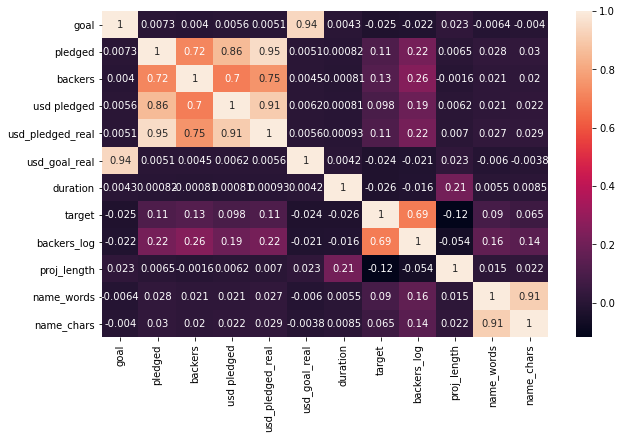

In [72]:
## Heatmap of numberical categories
plt.subplots(figsize=(10,6))
sns.heatmap(kick.corr(), annot=True)

# 4 -- Machine Learning Classifier

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Encoding / Training

In [74]:
kick.drop(columns=["usd pledged", "usd_pledged_real", "duration"], inplace=True)
kick.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,backers_log,proj_length,name_words,name_chars
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,1533.95,0,0.000000,59,6,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,30000.00,0,1.176091,60,8,45
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,45000.00,0,0.477121,45,3,14
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,5000.00,0,0.000000,30,7,49
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,19500.00,0,1.146128,56,8,58


### Select Features

The features we want are the ones that a Kickstarter project starter can control when they set up their Kickstarter. Things like backers or pledged amounts should not be things that they already know, so we will be dropping those together with our success/failure columns (target/state).

Name itself will be dropped since we will not want to One Hot Encode over 300,000 rows of data there and it is meaningless since there should be no repeats. In it's place, we are keeping the name_words, name_chars columns.

Deadline and Launched will be dropped as well since we created a new column for project length. In a future iteration of this project, we can consider extracting more information out of the actual deadline month/year to see if there was any correlation or influence from that information.

In [75]:
## Set X, y
X = kick.drop(['backers', 'name', 'deadline', 'launched', 'state', 'pledged', 'backers_log', 'goal', 'target'], axis=1)
y = kick['target']

In [76]:
for column in ["main_category","category", "currency", "country"]:
    temp = pd.get_dummies(X[column], drop_first=True, prefix=column)
    X = X.join(temp)
    del X[column]

In [77]:
X.head()

,usd_goal_real,proj_length,name_words,name_chars,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,1533.95,59,6,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30000.00,60,8,45,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,45000.00,45,3,14,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,5000.00,30,7,49,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,19500.00,56,8,58,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [78]:
## Goal amount in log format
X["usd_goal_real"] = np.log(X["usd_goal_real"])
kick.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,backers_log,proj_length,name_words,name_chars
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,1533.95,0,0.000000,59,6,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,30000.00,0,1.176091,60,8,45
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,45000.00,0,0.477121,45,3,14
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,5000.00,0,0.000000,30,7,49
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,19500.00,0,1.146128,56,8,58


### Split Data

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling Features

In [80]:
scaler = MinMaxScaler(feature_range=(1, 10))

Scale features to make their relative weighting similar to other features

In [81]:
X_train = scaler.fit_transform(X_train)

In [82]:
X_test = scaler.transform(X_test)

# Machine Learning Modeling

The idea here is to run it through several models and see which ones provide the best preliminary results. Models we will be looking at initially are: 


> Decision Tree Classifier

> Random Forest Classifier

> Logistic Regression 

> AdaBoost Classifier

> XGBoost Classifier

> KNN Classifier

**Key evaluation factors are:**

> Accuracy Score

> F1 Score

> Precision

> Recall

After running the models through once with some baseline parameters, we will run a GridSearch or RandomSearch on each model to try and tune for optimal parameters, before finally running a 'final' model off the tuned parameters. We will evaluate those models one more time to help us see which is best.

# 3.1 -- Decision Tree

In [100]:
from sklearn.tree import DecisionTreeClassifier

In [94]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [95]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 1, 1])

In [96]:
print('DECISION TREE')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

DECISION TREE
Confusion Matrix
[12387, 13846]
[14318, 33909]

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.71      0.71     47755
           1       0.47      0.46      0.47     26705

    accuracy                           0.62     74460
   macro avg       0.59      0.59      0.59     74460
weighted avg       0.62      0.62      0.62     74460

Accuracy Score
0.6217566478646253


### Grid Search

In [97]:
parameters = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
}

search = GridSearchCV(
    DecisionTreeClassifier(),
    parameters,
    verbose=3,
    n_jobs=-1
    )

search.fit(X_train, y_train)
print('DECISION TREE - GRID SEARCH')
print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:   58.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:  1.8min remaining:   27.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.9min finished


DECISION TREE - GRID SEARCH
0.685535858178888
{'max_depth': 11}


### Using Tuned Parameters

In [98]:
model = DecisionTreeClassifier(max_depth=11)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11)

In [99]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 0, 0])

In [100]:
print('DECISION TREE')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

DECISION TREE
Confusion Matrix
[9044, 5700]
[17661, 42055]

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.88      0.78     47755
           1       0.61      0.34      0.44     26705

    accuracy                           0.69     74460
   macro avg       0.66      0.61      0.61     74460
weighted avg       0.67      0.69      0.66     74460

Accuracy Score
0.6862610797743754


# 3.2 -- Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
model = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-1, random_state=42)

In [103]:
predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [104]:
print('RANDOM FOREST')
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

RANDOM FOREST
Confusion Matrix
[2353, 950]
[24352, 46805]

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.98      0.79     47755
           1       0.71      0.09      0.16     26705

    accuracy                           0.66     74460
   macro avg       0.69      0.53      0.47     74460
weighted avg       0.68      0.66      0.56     74460

Accuracy Score
0.6601933924254634


### Grid Search

In [105]:
parameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
}

search = GridSearchCV(
    RandomForestClassifier(),
    parameters,
    verbose=1,
    n_jobs=-1
    )
search.fit(X_train, y_train)

print('RANDOM FOREST - GRID SEARCH')
print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 17.2min finished


RANDOM FOREST - GRID SEARCH
0.6854015578834274
{'max_depth': 15, 'n_estimators': 50}


### Used Tuned Parameters

In [106]:
model = RandomForestClassifier(max_depth=15, n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=42)

In [107]:
predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [111]:
print('RANDOM FOREST')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

RANDOM FOREST
Confusion Matrix
[6210, 2982]
[20495, 44773]

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.94      0.79     47755
           1       0.68      0.23      0.35     26705

    accuracy                           0.68     74460
   macro avg       0.68      0.59      0.57     74460
weighted avg       0.68      0.68      0.63     74460

Accuracy Score
0.6847031963470319


# 3.2 -- Logistic Regression

In [112]:
from sklearn.linear_model import LogisticRegression

In [113]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [114]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 1, 0])

In [115]:
print('LOGISTIC REGRESSION')
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

LOGISTIC REGRESSION
Confusion Matrix
[10729, 6997]
[15976, 40758]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     47755
           1       0.61      0.40      0.48     26705

    accuracy                           0.69     74460
   macro avg       0.66      0.63      0.63     74460
weighted avg       0.68      0.69      0.67     74460

Accuracy Score
0.6914719312382487


### Grid Search

In [116]:
parameters = {'C':np.linspace(.01,1)}
search = GridSearchCV(LogisticRegression(), parameters, verbose=3, n_jobs=-1)
search.fit(X_train, y_train)
print('LOGISTIC REGRESSION - GRID SEARCH')
print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 45.0min finished


LOGISTIC REGRESSION - GRID SEARCH
0.6906963470319636
{'C': 0.6969387755102041}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Using Tuned Parameters

In [117]:
model = LogisticRegression(max_iter=1000, C=0.5555102040816327)
model.fit(X_train, y_train)

LogisticRegression(C=0.5555102040816327, max_iter=1000)

In [118]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 1, 0])

In [119]:
print('LOGISTIC REGRESSION')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

LOGISTIC REGRESSION
Confusion Matrix
[10730, 6998]
[15975, 40757]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     47755
           1       0.61      0.40      0.48     26705

    accuracy                           0.69     74460
   macro avg       0.66      0.63      0.63     74460
weighted avg       0.68      0.69      0.67     74460

Accuracy Score
0.6914719312382487


# 3.4 -- XGBoost

In [84]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [85]:
model = XGBClassifier(subsample=0.7, n_estimators=100, min_child_weight=3, max_depth=7, learning_rate=0.1)
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
predictions = model.predict(X_test)
predictions

array([0, 1, 1, ..., 0, 0, 0])

In [87]:
print('XGBoost')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

XGBoost
Confusion Matrix
[10921, 6385]
[15784, 41370]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.87      0.79     47755
           1       0.63      0.41      0.50     26705

    accuracy                           0.70     74460
   macro avg       0.68      0.64      0.64     74460
weighted avg       0.69      0.70      0.68     74460

Accuracy Score
0.702269674993285


### Grid Search

Lost the parameters originally used for the search. Placeholder parameters now.

In [91]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'learning _rate' : [ 0.01, 0.03, 0.05, 0.07, 0.1 ],
    'max_depth' : [ 10, 20, 50, 80, 110 ],
}

search = RandomizedSearchCV(
    XGBClassifier(),
    parameters,
    verbose=3,
    n_jobs=-1
    )

search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed: 156.2min remaining: 60.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 175.7min finished
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { learning _rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [92]:
print('XGBoost - GRID SEARCH')

print(search.best_score_)
print(search.best_params_)

XGBoost - GRID SEARCH
0.700416330915928
{'max_depth': 10, 'learning _rate': 0.07}


### Using Tuned Parameters

In [93]:
model = XGBClassifier(subsample=0.7, n_estimators=100, min_child_weight=3, max_depth=7, learning_rate=0.1)
model.fit(X_train, y_train)

[23:33:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
predictions = model.predict(X_test)
predictions

array([0, 1, 1, ..., 0, 0, 0])

In [95]:
print('XGBOOST')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

XGBOOST
Confusion Matrix
[10921, 6385]
[15784, 41370]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.87      0.79     47755
           1       0.63      0.41      0.50     26705

    accuracy                           0.70     74460
   macro avg       0.68      0.64      0.64     74460
weighted avg       0.69      0.70      0.68     74460

Accuracy Score
0.702269674993285


# 3.5 -- AdaBoost

In [101]:
from sklearn.ensemble import AdaBoostClassifier

In [102]:
model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=11), n_estimators=50,learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=11),
                   learning_rate=0.05, random_state=42)

In [103]:
predictions = model.predict(X_test)
predictions

array([0, 1, 1, ..., 0, 0, 0])

In [104]:
print('AdaBoost')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

AdaBoost
Confusion Matrix
[10891, 7232]
[15814, 40523]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     47755
           1       0.60      0.41      0.49     26705

    accuracy                           0.69     74460
   macro avg       0.66      0.63      0.63     74460
weighted avg       0.68      0.69      0.67     74460

Accuracy Score
0.6904915390813859


### Grid Search

In [105]:
parameters = {
    
    'learning _rate' : [ 0.01, 0.03, 0.05, 0.07, 0.1 ],
    'max_depth' : range(3,16),
}


from sklearn.ensemble import AdaBoostClassifier
parameters = {"learning_rate": [0.1, 0.01, 0.05, 0.001],
               "n_estimators": [50, 100, 150]}

search = GridSearchCV(
    AdaBoostClassifier(),
    parameters,
    verbose=3,

    )

search.fit(X_train, y_train)

print('AdaBoost - GRID SEARCH')

print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] learning_rate=0.1, n_estimators=50 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. learning_rate=0.1, n_estimators=50, score=0.651, total= 1.2min
[CV] learning_rate=0.1, n_estimators=50 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] .. learning_rate=0.1, n_estimators=50, score=0.651, total= 1.3min
[CV] learning_rate=0.1, n_estimators=50 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] .. learning_rate=0.1, n_estimators=50, score=0.650, total= 1.3min
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] .. learning_rate=0.1, n_estimators=50, score=0.650, total= 1.3min
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] .. learning_rate=0.1, n_estimators=50, score=0.652, total= 1.3min
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] . learning_rate=0.1, n_estimators=100, score=0.672, total= 2.6min
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] . learning_rate=0.1, n_estimators=100, score=0.669, total= 2.6min
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] . learning_rate=0.1, n_estimators=100, score=0.670, total= 2.5min
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] . learning_rate=0.1, n_estimators=100, score=0.671, total= 2.6min
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 152.5min finished


AdaBoost - GRID SEARCH
0.6793043244695138
{'learning_rate': 0.1, 'n_estimators': 150}


### Using Tuned Parameters

In [106]:
model = AdaBoostClassifier(n_estimators=150,learning_rate=0.1)
model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=150)

In [107]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 0, 0])

In [108]:
print('AdaBOOST')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

AdaBOOST
Confusion Matrix
[6059, 3246]
[20646, 44509]

Classification Report
              precision    recall  f1-score   support

           0       0.68      0.93      0.79     47755
           1       0.65      0.23      0.34     26705

    accuracy                           0.68     74460
   macro avg       0.67      0.58      0.56     74460
weighted avg       0.67      0.68      0.63     74460

Accuracy Score
0.679129734085415


# 3.6 -- KNN

Did not end up using because took too long to run. Code should work if time allows.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train, y_train)

In [ ]:
predictions = model.predict(X_test)
predictions

In [ ]:
print('KNN')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

### Grid Search

In [ ]:
parameters = {
    'n_neighbors': list(range(3,26,2))
}

search = GridSearchCV(
    KNeighborsClassifier(),
    parameters,
    verbose=1,
    n_jobs=-1
    )

search.fit(X_train, y_train)

print('KNN - GRID SEARCH')

print(search.best_score_)
print(search.best_params_)

# 4 -- Conclusion

In [2]:
kick_model = pd.read_csv('/Users/wonghuiee/Google Drive/Xccelerate - Data Science/02MachineLearning/Group Project - Kickstarter/Xccelerate Machine Learning -- Prediction Models.csv')

In [3]:
kick_model.head()

,model,accuracy,Model Version
0,Decision Tree,62.25,Base
1,Decision Tree,68.58,Gridsearched
2,Random Forest,65.97,Base
3,Random Forest,68.51,Gridsearched
4,Logistic Regression,68.44,Base


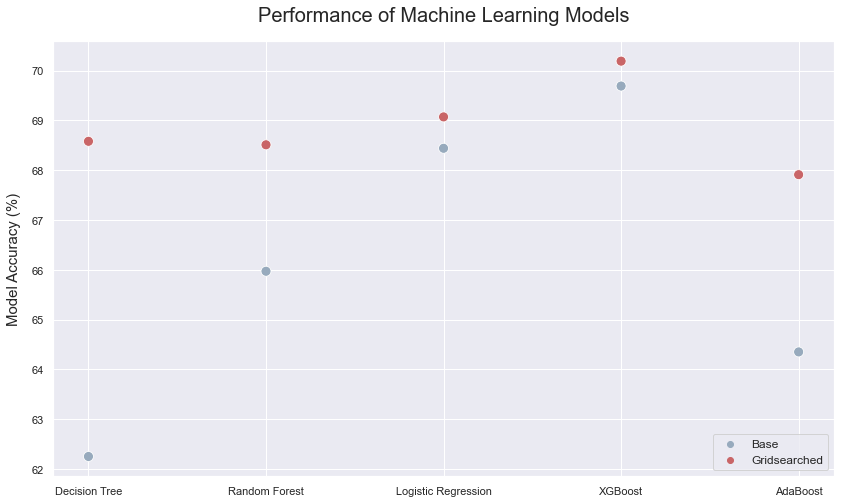

In [8]:
plt.subplots(figsize=(14,8))
colors = ["#97AABD","#C96567"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data=kick_model, x='model', y='accuracy', hue='Model Version', s=100)
sns.set_theme(context='notebook', style='darkgrid')
plt.title('Performance of Machine Learning Models', fontsize=20, pad=20)
plt.xlabel('', labelpad=10, fontsize=15)
plt.ylabel('Model Accuracy (%)', labelpad=10, fontsize=15)
plt.legend(loc='lower right', prop={'size':12})